In [71]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# ! pip install matplotlib pandas
# ! pip3 install torch torchvision torchaudio

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fqr1pv5i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fqr1pv5i
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done


In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image


print("Torch version:", torch.__version__)


/home/toluwani/anaconda3/envs/hawau/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.13.0+cu117


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import pandas as pd 
import os 
HOME = os.environ.get("HOME")

In [8]:
!mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations}

!unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/

In [9]:
!mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations}
!mv $HOME/.cache/torch/mmf/data/datasets/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
!mv $HOME/.cache/torch/mmf/data/datasets/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/

In [10]:
!ls {HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations

dev_seen.jsonl	  test_seen.jsonl    train.jsonl
dev_unseen.jsonl  test_unseen.jsonl  train_updated.jsonl


### Load Hateful Meme Dataset

In [11]:
import pandas as pd
import os

HOME = os.environ.get("HOME")
images_path = f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/"
annotations_path = f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)


In [12]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [13]:
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ['train', 'dev_seen', 'dev_unseen', 'test_seen', 'test_unseen']
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(f"\nIn total there are {total_size} images,",
          "\nBut the # of images in /images directory is: ", len(a))

#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /images directory is:  12140


In [14]:
print("#of images that are not in one of the .jsonl files: ", 
      len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))))

#of images that are not in one of the .jsonl files:  0


In [15]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}")

#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [16]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(f"{annotations_path}/train_updated.jsonl", orient="records", lines=True)
train.shape, train_updated.shape

((8500, 4), (8600, 4))

## Write the dataset class

In [17]:
train.head(1)

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters


In [18]:
train.loc[0,"img"].split("/")[1]

'42953.png'

In [19]:
class HMDataset(Dataset):
    def __init__(self, images_path: str, annotation_path: str, image_transform=None, text_transform=None) -> None:
        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(".jsonl"), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)      

    def __len__(self):
        return self.annotation.shape[0]

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path, self.annotation.loc[index,"img"].split("/")[1])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index,"text"]
        label = self.annotation.loc[index,"label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)

In [20]:
hm_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", )
len(hm_dataset)

8600

In [21]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [22]:
model, preprocess = clip.load("ViT-B/32")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [23]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict

/home/toluwani/anaconda3/envs/hawau/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  import sys


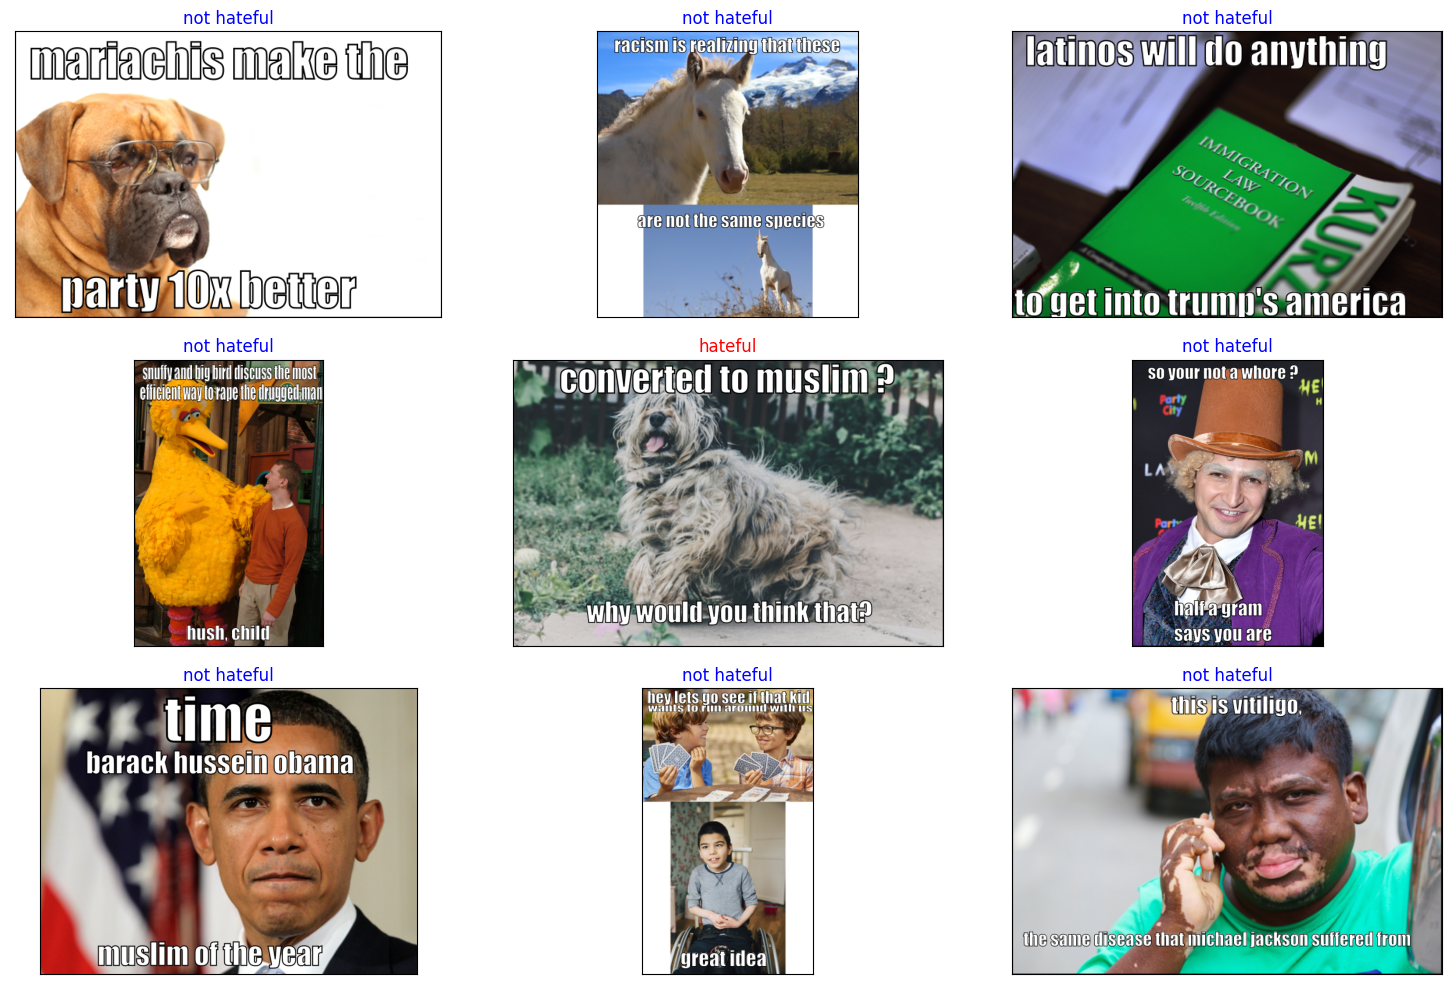

In [24]:
hm_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None)

plt.figure(figsize=(16, 10))

label_map = {1:"hateful", 0:"not hateful"}

for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):
    image, text, label = hm_dataset[idx]

    plt.subplot(3, 3, i+1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label.item()], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class HMMLP(nn.Module):

    def __init__(self, n_in=512*512, n_out=1, ) -> None:
        super().__init__()

        self.fc1 = nn.Linear(n_in, n_in/512)
        self.fc2 = nn.Linear( n_in/512, n_in/1024)
        # self.fc3 = nn.Linear(64, 16)
        # self.fc4 = nn.Linear(16, n_out)

    def forward(self, x):
        
        x = self.fc1(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = self.fc4(x)

        return x

In [160]:
# import torch.nn as nn
# import torch.nn.functional as F

# class HM(nn.Module):

#     def __init__(self, n_in=512*2, n_out=1, ) -> None:
#         super().__init__()

#         self.fc1 = nn.Linear(n_in, 4096)
#         self.fc2 = nn.Linear(4096, 512)
#         self.fc = nn.Linear(512, n_out)

#     def forward(self, x):
#         x = F.dropout(F.relu(self.fc1(x)))
#         x = F.dropout(F.relu(self.fc2(x)))
#         x = self.fc(x)
#         return x

In [26]:
batch_size = 32

def text_preprocess(text):
    return clip.tokenize(text, truncate=True)

hm_train_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", image_transform=preprocess, text_transform=text_preprocess)
hm_test_dataset = HMDataset(images_path, f"{annotations_path}/test_unseen.jsonl", image_transform=preprocess, text_transform=text_preprocess)
hm_val_dataset = HMDataset(images_path, f"{annotations_path}/dev_unseen.jsonl", image_transform=preprocess, text_transform=text_preprocess)

train_dataloader = DataLoader(hm_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(hm_val_dataset, batch_size=batch_size, shuffle=True)

In [27]:
data = next(iter(train_dataloader))

In [28]:
images, texts, labels = data
images.shape, texts.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 77]), torch.Size([32]))

In [29]:
net = HMMLP()
images, texts, labels = data
images = images.to(device)
texts = texts.to(device)
labels = labels.to(device).float()

with torch.no_grad():
    images = model.encode_image(images)
    texts = model.encode_text(texts.squeeze())

In [30]:
images.shape, texts.shape, labels.shape

(torch.Size([32, 512]), torch.Size([32, 512]), torch.Size([32]))

In [36]:
cross = torch.bmm(images.unsqueeze(2), texts.unsqueeze(1))
cross = cross.reshape(cross.shape[0],-1)

torch.Size([32, 512, 512])

In [166]:
net = net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer.zero_grad()

In [167]:
fused = torch.hstack((images,texts))
fused.requires_grad

False

In [168]:
fused.requires_grad_()
fused.requires_grad

True

In [169]:
output = net(fused.float())

In [170]:
output.shape, labels.shape

(torch.Size([32, 1]), torch.Size([32]))

In [171]:
labels.squeeze()

tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')

In [172]:
output.squeeze(), labels.squeeze()

(tensor([ 1.4378e-01,  7.9160e-03,  1.7040e-02, -2.4781e-02,  5.3251e-02,
         -1.8060e-02,  9.5232e-02,  4.7031e-02, -1.1817e-04, -6.9233e-04,
          6.9688e-04, -1.1615e-01,  1.1152e-01, -3.1967e-02, -1.5539e-01,
          9.1786e-02,  1.5509e-01,  3.9423e-02,  4.3079e-02, -9.5414e-03,
         -6.3347e-02,  1.6713e-03,  6.4670e-02, -1.2733e-02,  5.6891e-02,
         -4.9769e-02, -5.9042e-03,  5.3156e-02,  1.3651e-01,  1.2958e-01,
          2.5342e-02, -3.1312e-02], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
        device='cuda:0'))

In [173]:
o = F.sigmoid(output).squeeze().round()
o

/home/toluwani/anaconda3/envs/hawau/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [174]:
loss = criterion(output.squeeze(), labels.squeeze())
loss.backward()
optimizer.step()

In [44]:
from torchmetrics import AUROC

In [45]:
net = HMMLP()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=1e-3)

epochs = 100
print_every = 50

for epoch in range(epochs):
    
    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        with torch.no_grad():
            images = model.encode_image(images) # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(texts.squeeze()) # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        # fused_images_texts = torch.hstack((images,texts))
        # fused_images_texts = torch.bmm(images,texts)
        
        cross = torch.bmm(images.unsqueeze(2), texts.unsqueeze(1))
        cross = cross.reshape(cross.shape[0],-1)

        # fused_images_texts.requires_grad_()
        # fused_images_texts = fused_images_texts.float()

        cross.requires_grad_()
        cross = cross.float()

        optimizer.zero_grad()

        # Forward pass on the fused data

        # output = net(fused_images_texts)

        output = net(cross)

        loss = criterion(output.squeeze(), labels)

        # Compute gradient
        loss.backward()

        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i%print_every==(print_every - 1): 
            
            print(f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/print_every:.5f}")
            running_loss = 0.0

    ## Switch to eval mode
    net.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i, data in enumerate(val_dataloader, 0):
        
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        with torch.no_grad():
            images = model.encode_image(images) # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(texts.squeeze()) # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        # fused_images_texts = torch.hstack((images,texts))
        # fused_images_texts.requires_grad_()
        # fused_images_texts = fused_images_texts.float()

        cross = torch.bmm(images.unsqueeze(2), texts.unsqueeze(1))
        cross = cross.reshape(cross.shape[0],-1)
        cross.requires_grad_()
        cross = cross.float()

        with torch.no_grad():
            # output = net(fused_images_texts)
            output = net(cross)
            


        loss = criterion(output.squeeze(), labels)

        running_loss += loss.item()

        correct_preds += sum(F.sigmoid(output).squeeze().round()==labels)
        total_preds += len(labels)

        auroc = AUROC(pos_label=1)
        auroc_score = auroc(output, labels.int())

    print(f"\n[Epoch {epoch +1}, step {i+1:3d}] val loss: {running_loss/i+1:.5f} accuracy: {correct_preds/total_preds} auroc: {auroc_score}\n")

    
print("Finished Training!")
        

[Epoch 1, step  50] loss: 0.65348
[Epoch 1, step 100] loss: 0.60076
[Epoch 1, step 150] loss: 0.61822
[Epoch 1, step 200] loss: 0.61564
[Epoch 1, step 250] loss: 0.60824


/home/toluwani/anaconda3/envs/hawau/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/toluwani/anaconda3/envs/hawau/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/toluwani/anaconda3/envs/hawau/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Argument `pos_label` should be `None` when running multiclass precision recall curve. Got 1
  warnings.warn(*args, **kwargs)


TypeError: trapz() received an invalid combination of arguments - got (list, list, dim=int), but expected one of:
 * (Tensor y, *, float dx, int dim)
 * (Tensor y, Tensor x, *, int dim)


In [46]:
labels

tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')

In [52]:
F.sigmoid(output).squeeze().round()

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       device='cuda:0')